# Importing Libraries

In [1]:
import numpy as np
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import cross_val_score

# Preprocessing Data

## Loading Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# import pandas as pd

# file_path = '/content/drive/MyDrive/ML-Project/dataset-01'

# train_df = pd.read_csv(f'{file_path}/train.csv')
# valid_df = pd.read_csv(f'{file_path}/valid.csv')




In [2]:
import pandas as pd

file_path = './dataset-01'

train_df = pd.read_csv(f'{file_path}/train.csv')
valid_df = pd.read_csv(f'{file_path}/valid.csv')
test_df = pd.read_csv(f'{file_path}/test.csv')


In [14]:
train_df.shape


(28520, 772)

In [4]:
L1 = 'label_1'
L2 = 'label_2'
L3 = 'label_3'
L4 = 'label_4'

labels = [L1, L2, L3, L4]
features = [f'feature_{i}' for i in range(1, 769)]

X_train = {}
y_train = {}

X_valid = {}
y_valid = {}


X_test = test_df.drop('ID', axis=1)
test_predicts = {}


## Scaling Data


In [5]:
from sklearn.preprocessing import RobustScaler

for label in labels:
  tr_df = train_df[train_df[L2].notna()] if label == L2 else train_df
  val_df = valid_df[valid_df[L2].notna()] if label == L2 else valid_df

  scalar = RobustScaler()

  X_train[label] = pd.DataFrame(scalar.fit_transform(tr_df.drop(labels, axis=1)), columns=features)
  y_train[label] = tr_df[label]

  X_valid[label] = pd.DataFrame(scalar.transform(val_df.drop(labels, axis=1)), columns=features)
  y_valid[label] = val_df[label]

  pd.DataFrame(scalar.transform(X_test), columns=features)

# Main functions

## Classifier

In [6]:
def svm_classifier(X_train, y_train, class_weight=None):
    clf = svm.SVC(class_weight=class_weight)
    clf.fit(X_train, y_train)
    return clf

## Get model performance

In [7]:
def printValidationPerformance(clf, X, y):

  y_pred = clf.predict(X)
  
  # print(metrics.confusion_matrix(y, y_pred))
  print('Accuracy: ', metrics.accuracy_score(y, y_pred))
  print('Precision: ', metrics.precision_score(y, y_pred, average='weighted'))
  print('F1 score: ', metrics.f1_score(y, y_pred, average='weighted'))

## Methods for hyperparameter tuning

In [8]:
def random_search(clf, param_grid, cv, n_iter, X_train, y_train):

    grid = RandomizedSearchCV(clf, param_grid, n_iter=n_iter, n_jobs=-1, cv=cv, verbose=1, scoring='accuracy')
    grid.fit(X_train, y_train)
    return grid

## Cross Validation

In [9]:
def cross_validation(clf, k, X_train, y_train):

    scores = cross_val_score(clf, X_train, y_train, cv=k)
    mean_score = np.mean(scores)
    std_dev = np.std(scores)
    print("Scores:", scores)
    print("Mean Score:", mean_score)
    print("Standard Deviation:", std_dev)

# Label 01

## Performance before Feature Engineering

In [25]:
clf = svm_classifier(X_train[L1], y_train[L1])

### Training Performance

In [ ]:
printValidationPerformance(clf, X_train[L1], y_train[L1])

### Validation Performance

In [27]:
printValidationPerformance(clf, X_valid[L1], y_valid[L1])

[[12  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ... 20  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  9]]
0.9333333333333333
0.9452355220023642
0.9351216087549016


## Feature Engineering

C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='label_1', ylabel='count'>

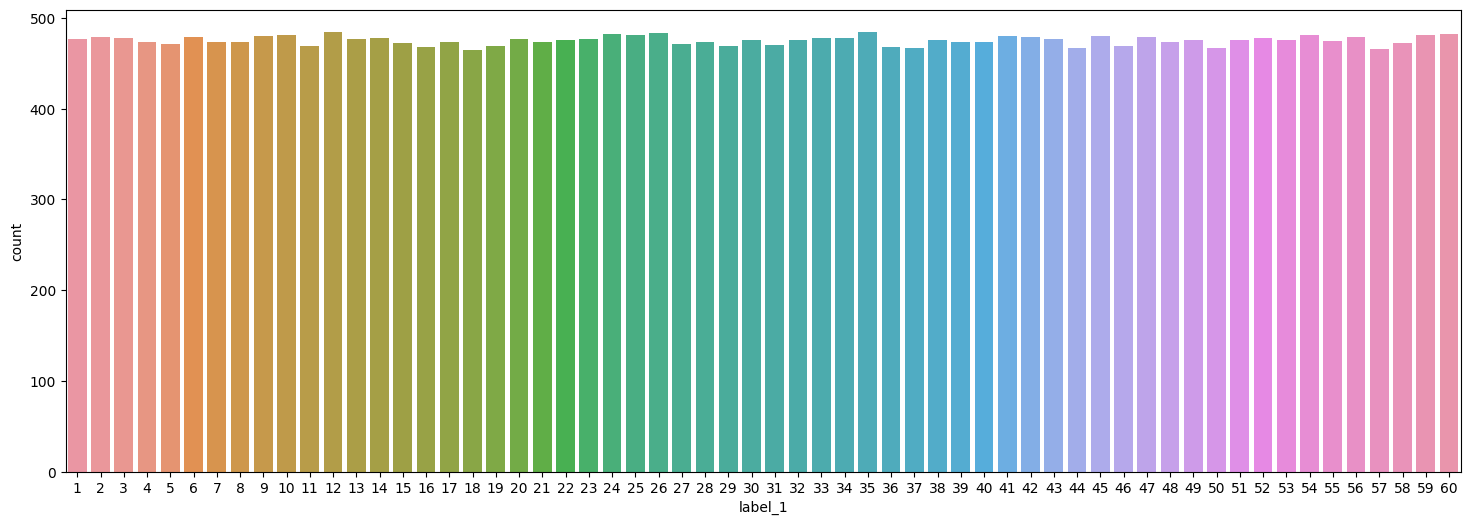

In [10]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x=L1)

### Feature selection - univariant feature selection

In [11]:
selector = SelectKBest(k=200)
X_train_skb = selector.fit_transform(X_train[L1], y_train[L1])

In [ ]:
X_train_skb.shape

(28520, 200)

In [ ]:
clf_1 = svm_classifier(X_train_skb, y_train[L1])

#### Training Accuracy

In [ ]:

printValidationPerformance(clf_1, X_train_skb, y_train[L1])

Accuracy:  0.9700911640953717
Precision:  0.9747144179652726
F1 score:  0.9713313553893205


#### Validataion Accuracy

In [ ]:
printValidationPerformance(clf_1, selector.transform(X_valid[L1]), y_valid[L1])

Accuracy:  0.944
Precision:  0.9553000298634973
F1 score:  0.9458136398610437


### Feature selection - PCA

In [52]:
from sklearn.decomposition import PCA

selector_pca = PCA(n_components=0.95, svd_solver='full')
X_train_pca = pd.DataFrame(selector_pca.fit_transform(X_train[L1]))

In [ ]:
X_train_pca.shape

(28520, 309)

In [ ]:
clf_pca = svm_classifier(X_train_pca, y_train[L1])

#### Training Accuracy

In [ ]:
printValidationPerformance(clf_pca, X_train_pca, y_train[L1])

[[454   0   0 ...   0   1   0]
 [  1 462   0 ...   0   0   0]
 [  0   0 456 ...   0   0   0]
 ...
 [  0   0   0 ... 460   1   0]
 [  0   0   0 ...   0 459   0]
 [  0   0   0 ...   0   1 465]]
0.9607293127629734
0.9684029808826552
0.9629124797796352


#### Validation Accuracy

In [ ]:
printValidationPerformance(clf_pca, selector_pca.transform(X_valid[L1]), y_valid[L1])

Accuracy:  0.9266666666666666
Precision:  0.9406282957782959
F1 score:  0.9289570234056749


## Hyperparameter Tuning 

In [57]:
clf = svm.SVC()

param_grid = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7)
    }

grid = random_search(clf, param_grid, cv=2, n_iter=5, X_train=X_train_pca, y_train=y_train[L1])

print('best parameters: ', grid.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


KeyboardInterrupt: 

### Validation Accuracy

In [61]:
#best parameters:  {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}

In [56]:
printValidationPerformance(grid.best_estimator_, selector_pca.transform(X_valid[L1]), y_valid[L1])

Accuracy:  0.944
Precision:  0.9475019394548807
F1 score:  0.944337468672387


## Cross Validation

In [67]:
model = svm.SVC(kernel='rbf', gamma=0.01, C=10)
cross_validation(model, 5, X_train_skb, y_train[L1])

Scores: [0.95687237 0.95441795 0.95546985 0.95196353 0.95617111]
Mean Score: 0.9549789621318373
Standard Deviation: 0.0017119993850958821


## Selected Parameters for L1

In [53]:
clf_L1 = svm.SVC(kernel='rbf', gamma=0.01, C=10)
clf_L1.fit(X_train_pca, y_train[L1])
X_test_L1 = selector.transform(X_test)

In [54]:
printValidationPerformance(clf_L1, selector_pca.transform(X_valid[L1]), y_valid[L1])

Accuracy:  0.9133333333333333
Precision:  0.9271645205270592
F1 score:  0.9153898649973083


# Label 02

## Performance before Feature Engineering

In [60]:
clf = svm_classifier(X_train[L2], y_train[L2])

### Training Performance

In [ ]:
printValidationPerformance(clf, X_train[L2], y_train[L2])

Accuracy:  0.9482524964336662
Precision:  0.9545732078280673
F1 score:  0.9494599761781872


### Validation Performance

In [ ]:
printValidationPerformance(clf, X_valid[L2], y_valid[L2])

Accuracy:  0.8980978260869565
Precision:  0.9106133951564483
F1 score:  0.8991987863206446


## Feature Engineering

C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='label_2', ylabel='count'>

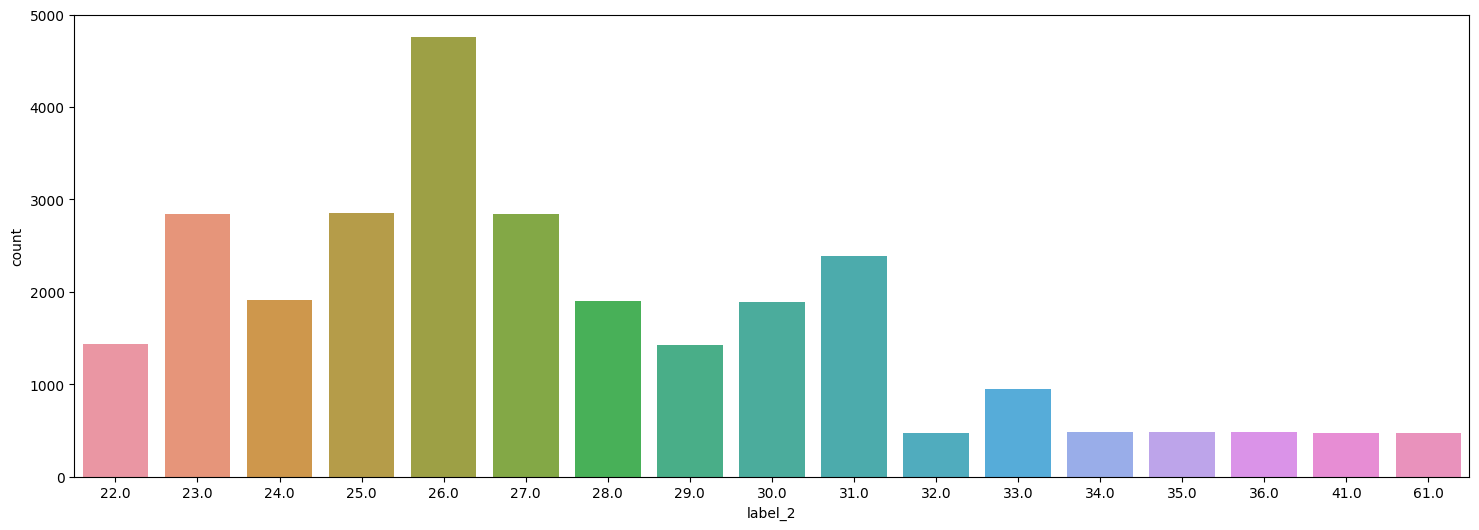

In [13]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x=L2)

### Feature selection - univariant feature selection

In [14]:
selector_L2 = SelectKBest(k=230)
X_train_skb_L2 = selector_L2.fit_transform(X_train[L2], y_train[L2])

In [ ]:
X_train_skb_L2.shape

(28040, 230)

In [ ]:
clf_2 = svm_classifier(X_train_skb_L2, y_train[L2])

#### Training Accuracy

In [ ]:

printValidationPerformance(clf_2, X_train_skb_L2, y_train[L2])

#### Validataion Accuracy

In [ ]:
printValidationPerformance(clf_2, selector_L2.transform(X_valid[L2]), y_valid[L2])

Accuracy:  0.9008152173913043
Precision:  0.9116724766944635
F1 score:  0.9020925657638259


### Feature selection - PCA

In [15]:
from sklearn.decomposition import PCA

selector_pca_L2 = PCA(n_components=0.96, svd_solver='full')
X_train_pca_L2 = pd.DataFrame(selector_pca_L2.fit_transform(X_train[L2]))

In [63]:
X_train_pca_L2.shape

(28040, 349)

In [64]:
clf_pca_L2 = svm_classifier(X_train_pca_L2, y_train[L2])

#### Training Accuracy

In [67]:
printValidationPerformance(clf_pca_L2, X_train_pca_L2, y_train[L2])

Accuracy:  0.9407988587731811
Precision:  0.9482568965956633
F1 score:  0.9422141112303217


#### Validation Accuracy

In [68]:
printValidationPerformance(clf_pca_L2, selector_pca_L2.transform(X_valid[L2]), y_valid[L2])

Accuracy:  0.8899456521739131
Precision:  0.9030320380298763
F1 score:  0.8911547812582737


## Hyperparameter Tuning 

In [69]:
clf_2 = svm.SVC()

param_grid = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

grid_2 = random_search(clf_2, param_grid, cv=2, n_iter=5, X_train=X_train_pca_L2, y_train=y_train[L2])

print('best parameters: ', grid_2.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
best parameters:  {'kernel': 'poly', 'gamma': 10.0, 'class_weight': 'balanced', 'C': 1.0}


### Validation Accuracy

In [70]:
printValidationPerformance(grid_2.best_estimator_, selector_pca_L2.transform(X_valid[L2]), y_valid[L2])

Accuracy:  0.9266304347826086
Precision:  0.9287490077502439
F1 score:  0.9264277636484752


## Cross Validation

In [71]:
model = svm.SVC(kernel='poly', gamma=10, C=1, class_weight='balanced')
cross_validation(model, 5, X_train_pca_L2, y_train[L2])

Scores: [0.42760342 0.66012839 0.68348787 0.68955064 0.47236091]
Mean Score: 0.5866262482168331
Standard Deviation: 0.11289197985503628


## Selected Parameters for L2

In [44]:
clf_L2 = svm.SVC(kernel='poly', gamma=10, C=1, class_weight='balanced')
clf_L2.fit(X_train_pca_L2, y_train[L2])
X_test_L2 = selector_pca_L2.transform(X_test)

# Label 03

## Performance before Feature Engineering

In [58]:
clf = svm_classifier(X_train[L3], y_train[L3])

### Training Performance

In [71]:
printValidationPerformance(clf, X_train[L3], y_train[L3])

Accuracy:  0.9482524964336662
Precision:  0.9545732078280673
F1 score:  0.9494599761781872


### Validation Performance

In [11]:
printValidationPerformance(clf, X_valid[L3], y_valid[L3])

Accuracy:  0.8980978260869565
Precision:  0.9106133951564483
F1 score:  0.8991987863206446


## Feature Engineering

C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='label_3', ylabel='count'>

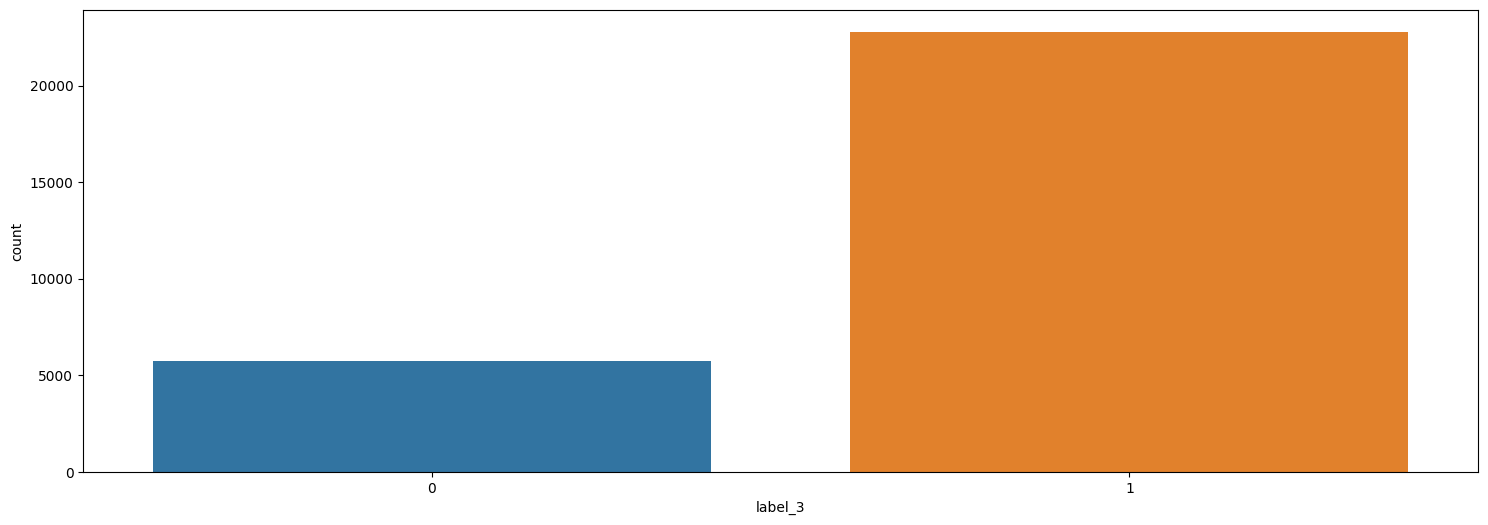

In [17]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x=L3)

### Feature selection - univariant feature selection

In [18]:
selector_skb_L3 = SelectKBest(k=200)
X_train_skb_L3 = selector_skb_L3.fit_transform(X_train[L3], y_train[L3])

In [77]:
X_train_skb_L3.shape

(28520, 200)

In [78]:
clf_3 = svm_classifier(X_train_skb_L3, y_train[L3], class_weight='balanced')

#### Training Accuracy

In [79]:

printValidationPerformance(clf_3, X_train_skb_L3, y_train[L3])

Accuracy:  0.9982819074333801
Precision:  0.9982832267412999
F1 score:  0.9982824126418717


#### Validataion Accuracy

In [80]:
printValidationPerformance(clf_3, selector_skb_L3.transform(X_valid[L3]), y_valid[L3])

Accuracy:  0.9973333333333333
Precision:  0.9973703703703705
F1 score:  0.99734046074738


### Feature selection - PCA

In [19]:
from sklearn.decomposition import PCA

selector_pca_L3 = PCA(n_components=0.95, svd_solver='full')
X_train_pca_L3 = pd.DataFrame(selector_pca_L3.fit_transform(X_train[L3]))

In [87]:
X_train_pca_L3.shape

(28520, 309)

In [88]:
clf_pca_L3 = svm_classifier(X_train_pca_L3, y_train[L3], class_weight='balanced')

#### Training Accuracy

In [89]:
printValidationPerformance(clf_pca_L3, X_train_pca_L3, y_train[L3])

Accuracy:  0.9978260869565218
Precision:  0.9978255788833592
F1 score:  0.9978258023900616


#### Validation Accuracy

In [90]:
printValidationPerformance(clf_pca_L3, selector_pca_L3.transform(X_valid[L3]), y_valid[L3])

Accuracy:  0.996
Precision:  0.9960827586206896
F1 score:  0.996015959509495


## Hyperparameter Tuning 

In [38]:
clf_3 = svm.SVC()

param_grid = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

grid_3 = random_search(clf_3, param_grid, cv=2, n_iter=5, X_train=X_train_skb_L3, y_train=y_train[L3])

print('best parameters: ', grid_3.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
best parameters:  {'kernel': 'linear', 'gamma': 1.0, 'class_weight': 'balanced', 'C': 0.1}


### Validation Accuracy

In [40]:
printValidationPerformance(grid_3.best_estimator_, selector_skb_L3.transform(X_valid[L3]), y_valid[L3])

Accuracy:  0.9866666666666667
Precision:  0.9870725210260095
F1 score:  0.9867715398499097


## Cross Validation

In [ ]:
model = grid_3.best_estimator_
cross_validation(model, 5, X_train_skb_L3, y_train[L3])

## Selected Parameters for L3

In [42]:
clf_L3 = svm.SVC(kernel='rbf', gamma=0.01, C=10, class_weight='balanced')
clf_L3.fit(X_train_skb_L3, y_train[L3])
X_test_L3 = selector_skb_L3.transform(X_test)

In [43]:
printValidationPerformance(clf_L3, selector_skb_L3.transform(X_valid[L3]), y_valid[L3])

Accuracy:  0.9986666666666667
Precision:  0.9986759906759908
F1 score:  0.9986684571511081


# Label 04

## Performance before Feature Engineering

In [ ]:
clf = svm_classifier(X_train[L4], y_train[L4])

### Training Performance

In [ ]:
printValidationPerformance(clf, X_train[L4], y_train[L4])

Accuracy:  0.9482524964336662
Precision:  0.9545732078280673
F1 score:  0.9494599761781872


### Validation Performance

In [ ]:
printValidationPerformance(clf, X_valid[L4], y_valid[L4])

Accuracy:  0.8980978260869565
Precision:  0.9106133951564483
F1 score:  0.8991987863206446


## Feature Engineering

C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\hgdni\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

<Axes: xlabel='label_4', ylabel='count'>

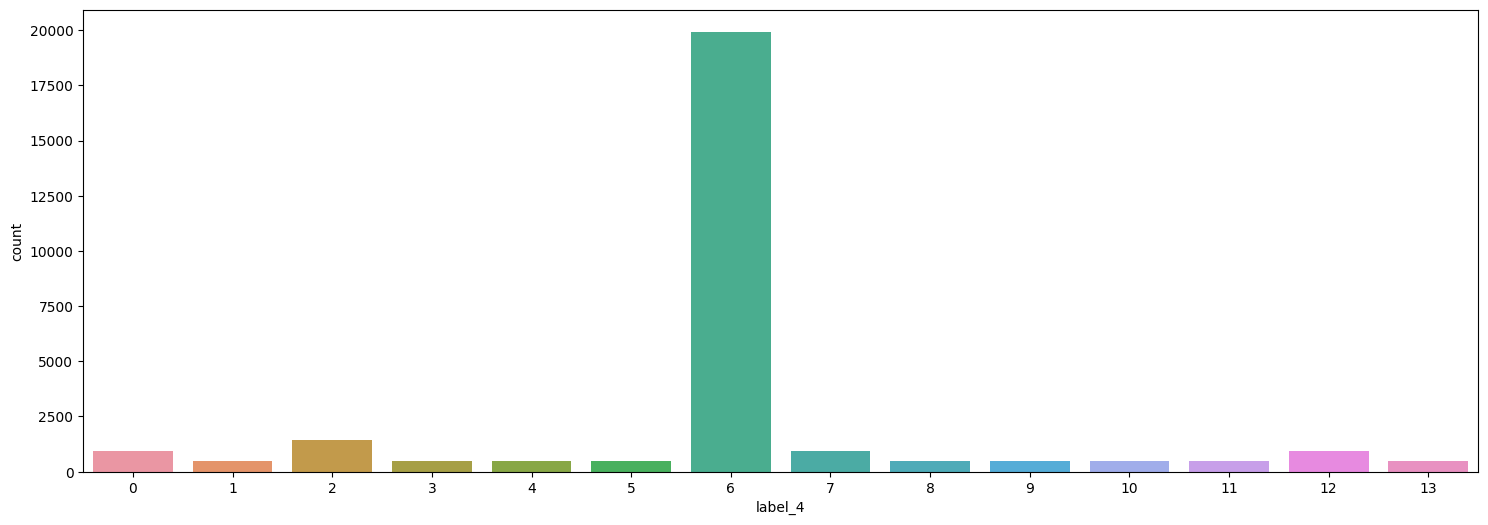

In [21]:
plt.figure(figsize=(18, 6))
sn.countplot(data=y_train, x=L4)

### Feature selection - univariant feature selection

In [22]:
selector_skb_L4 = SelectKBest(k=200)
X_train_skb_L4 = selector_skb_L4.fit_transform(X_train[L4], y_train[L4])

In [97]:
X_train_skb_L4.shape

(28520, 200)

In [98]:
clf_4 = svm_classifier(X_train_skb_L4, y_train[L4], class_weight='balanced')

#### Training Accuracy

In [99]:

printValidationPerformance(clf_4, X_train_skb_L4, y_train[L4])

Accuracy:  0.9331697054698457
Precision:  0.9471417805919986
F1 score:  0.9358717190307936


#### Validataion Accuracy

In [100]:
printValidationPerformance(clf_4, selector_skb_L4.transform(X_valid[L4]), y_valid[L4])

Accuracy:  0.916
Precision:  0.9329642135642136
F1 score:  0.9201325789071636


### Feature selection - PCA

In [23]:
from sklearn.decomposition import PCA

selector_pca_L4 = PCA(n_components=0.96, svd_solver='full')
X_train_pca_L4 = pd.DataFrame(selector_pca_L4.fit_transform(X_train[L4]))

In [102]:
X_train_pca_L4.shape

(28520, 350)

In [103]:
clf_pca_L4 = svm_classifier(X_train_pca_L4, y_train[L4], class_weight='balanced')

#### Training Accuracy

In [104]:
printValidationPerformance(clf_pca_L4, X_train_pca_L4, y_train[L4])

Accuracy:  0.9286816269284712
Precision:  0.9448552996991844
F1 score:  0.9319955445159553


#### Validation Accuracy

In [105]:
printValidationPerformance(clf_pca_L4, selector_pca_L4.transform(X_valid[L4]), y_valid[L4])

Accuracy:  0.9066666666666666
Precision:  0.9330172220075448
F1 score:  0.9135790242618318


## Hyperparameter Tuning 

In [24]:
clf_4 = svm.SVC()

param_grid = {
    'C': np.logspace(-3, 3, 7),
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': np.logspace(-3, 3, 7),
    'class_weight': ['balanced']
}

grid_4 = random_search(clf_4, param_grid, cv=2, n_iter=5, X_train=X_train_pca_L4, y_train=y_train[L4])

print('best parameters: ', grid_4.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
best parameters:  {'kernel': 'poly', 'gamma': 10.0, 'class_weight': 'balanced', 'C': 0.01}


### Validation Accuracy

In [26]:
printValidationPerformance(grid_4.best_estimator_, selector_pca_L4.transform(X_valid[L4]), y_valid[L4])

Accuracy:  0.9573333333333334
Precision:  0.9586052003353371
F1 score:  0.9560504120068893


## Cross Validation

In [27]:
model = svm.SVC(kernel='poly', gamma=10, C=0.01, class_weight='balanced')
cross_validation(grid_4.best_estimator_, 5, X_train_pca_L2, y_train[L2])

Scores: [0.42760342 0.66012839 0.68348787 0.68955064 0.47236091]
Mean Score: 0.5866262482168331
Standard Deviation: 0.11289197985503628


## Selected Parameters for L4

In [32]:
clf_L4 = grid_4.best_estimator_
X_test_L4 = selector_pca_L4.transform(X_test)

In [34]:
printValidationPerformance(clf_L4, selector_pca_L4.transform(X_valid[L4]), y_valid[L4])

Accuracy:  0.9573333333333334
Precision:  0.9586052003353371
F1 score:  0.9560504120068893


# Prediction

In [46]:
# Label 1
pred_L1 = clf_L1.predict(X_test_L1)
# Label 2
pred_L2 = clf_L2.predict(X_test_L2)
# Label 3
pred_L3 = clf_L3.predict(X_test_L3)
# Label 4
pred_L4 = clf_L4.predict(X_test_L4)

In [47]:
id_list = test_df['ID']

result = {
    'ID': id_list,
    'label_1': pred_L1,
    'label_2': pred_L2,
    'label_3': pred_L3,
    'label_4': pred_L4
}

result_df = pd.DataFrame(result)

result_df.to_csv('layer_8.csv', index=False)